In [1]:
import pandas as pd
import numpy as np
import keras_nlp
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import tensorflow as tf
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_hub as hub
import tensorflow_text as text
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

2024-04-24 18:59:58.227191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/stephcyrille/Ecole/projetIA/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using TensorFlow backend


## 1. Loading the dataset

In [2]:
df = pd.read_csv('../../data/processed/001_processed_df.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2045 entries, 0 to 2044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  2045 non-null   object
 1   label    2045 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.1+ KB


In [4]:
df.head()

,summary,label
0,Barracuda Brigade muslims busted stole million...,1
1,reasoning with facts attorney general loretta ...,1
2,Barracuda Brigade breaking weiner cooperating ...,1
3,Fed Up pin drop speech father daughter kidnapp...,1
4,Fed Up fantastic trumps point plan reform heal...,1


## 2. Loading BERT Model base

## 3. Building the Model

### 3.1. Spliting the dataset for the trainning

In [5]:
df = df.head(50)

x=df['summary']
y=df['label']

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42, stratify=y)

### 3.2. Scaffolding the model layers

In [6]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en_uncased",trainable=True)
  encoder_inputs = preprocessor(text_input)
  encoder = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [7]:
text_test = ['this is such an amazing movie!']

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

/Users/stephcyrille/Ecole/projetIA/.venv/lib/python3.9/site-packages/keras_nlp/src/models/backbone.py:93: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/stephcyrille/Ecole/projetIA/.venv/lib/python3.9/site-packages/keras_nlp/src/models/backbone.py:93: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


tf.Tensor([[0.09252227]], shape=(1, 1), dtype=float32)


In [8]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 bert_preprocessor (BertPre  {'token_ids': (None, 512),   0         ['text[0][0]']                
 processor)                   'segment_ids': (None, 512                                           
                             ),                                                                   
                              'padding_mask': (None, 51                                           
                             2)}                                                                  
                                                                                              

### 3.3. Adding lost functions and metrics

In [9]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [10]:
classifier_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=METRICS)

### 3.4. Fitting the model

In [11]:
history = classifier_model.fit(X_train, y_train, epochs=3)

Epoch 1/3
2/2 [==============================] - 216s 25s/step - loss: 10.0262 - accuracy: 0.3500 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/3
2/2 [==============================] - 156s 23s/step - loss: 10.0262 - accuracy: 0.3500 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/3
2/2 [==============================] - 153s 23s/step - loss: 10.0262 - accuracy: 0.3500 - precision: 0.0000e+00 - recall: 0.0000e+00


In [12]:
classifier_model.evaluate(X_test, y_test)

1/1 [==============================] - 15s 15s/step - loss: 10.7975 - accuracy: 0.3000 - precision: 0.0000e+00 - recall: 0.0000e+00


[10.797464370727539, 0.30000001192092896, 0.0, 0.0]

In [13]:
y_predicted = classifier_model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_predicted)

1/1 [==============================] - 14s 14s/step


Text(50.722222222222214, 0.5, 'Truth')

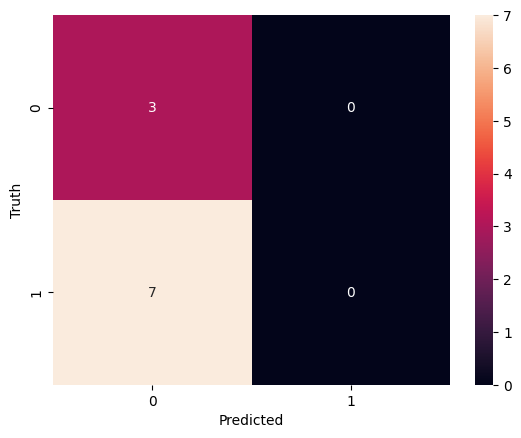

In [14]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth') 

# separation

In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [18]:
epochs = 5
steps_per_epoch = df.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [23]:
history = classifier_model.fit(x=X_train,
                               validation_data=y_train,
                               epochs=epochs)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().